<a href="https://colab.research.google.com/github/imfime/hello-world/blob/master/code_practices/Pretrained_ResNet18_ImageNet_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **사전 학습된(Pre-trained) ResNet 사용해보기**

* 본 실습에서는 ResNet18 모델을 이용해 이미지 분류(classification) 실습을 진행합니다.
  * PyTorch Hub 공식 ResNet18 아키텍처를 이용해 학습된 모델을 이용합니다.
* 코드 실행 전에 **\[런타임\]** → **\[런타임 유형 변경\]** → 유형을 **GPU**로 설정합니다.

In [1]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [2]:
# GPU 장치 사용 설정
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### **이미지넷(ImageNet)에 정의된 클래스 정보 가져오기**

In [3]:
from urllib.request import urlretrieve
import json

# 이미지넷(ImageNet)에 정의된 1,000개의 레이블(클래스) 정보 가져오기
imagenet_json, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [4]:
# 인덱스(index) 18에 해당하는 클래스는 까치(magpie)입니다.
print(imagenet_labels[18])

magpie


#### **이미지 처리 함수 정의 및 이미지 가져와 출력해보기**

* ResNet은 일반적으로 이미지에 대하여 **Resize**, **CenterCrop**, **ToTensor()**와 **입력 데이터 정규화**를 사용하는 모델입니다.

In [5]:
preprocess = transforms.Compose([
    transforms.Resize(256), # 이미지의 크기를 변경
    transforms.CenterCrop(224), # 이미지의 중앙 부분을 잘라서 크기 조절
    transforms.ToTensor(), # torch.Tensor 형식으로 변경 [0, 255] → [0, 1]
])

In [6]:
# 이미지(그림) 출력 관련 라이브러리
import matplotlib.pyplot as plt
import PIL

In [7]:
# 특정한 경로에서 이미지를 가져와 torch.Tensor로 변환하는 함수
def image_loader(path):
    image = PIL.Image.open(path)
    # 전처리 이후에 네트워크 입력에 들어갈 이미지에 배치 목적의 차원(dimension) 추가
    image = preprocess(image).unsqueeze(0)
    return image.to(device, torch.float) # GPU로 올리기

In [13]:
# 실제로 특정 URL에서 이미지를 불러오기 (얼룩 고양이)
#url = "http://www.image-net.org/nodes/10/02123045/6c/6c34fe7c9d846c33a2f1a9b47a766b44ab4ec70d.thumb"
url = "https://previews.123rf.com/images/evdoha/evdoha1209/evdoha120903876/15427542-%EB%91%90%EB%A0%A4%EC%9B%8C-%EC%96%BC%EB%A3%A9-%EA%B3%A0%EC%96%91%EC%9D%B4.jpg"
image_path, _ = urlretrieve(url)
image = image_loader(image_path)

In [14]:
# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
    image = image.squeeze(0)
    # PIL 객체로 변경 
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 처리)
    plt.imshow(image)

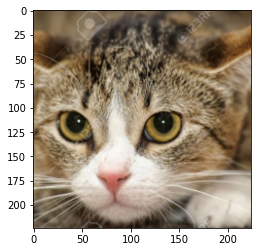

In [15]:
plt.figure()
imshow(image)

#### **사전 학습된(pretrained) 모델을 불러와 사용해보기**

In [16]:
# 입력 데이터 정규화를 위한 클래스 정의
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [17]:
# 공격자가 가지고 있는 torch.Tensor 형식의 이미지 데이터는 입력 정규화를 거치기 전이므로, 정규화 이후에 모델에 넣도록 설정
model = nn.Sequential(
    # 기본적인 ResNet18과 동일한 동작을 위하여 정규화 레이어 추가
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
).to(device).eval() # 모델을 GPU로 옮기기 및 평가(테스트) 모드로 변경

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [18]:
# 기본적인 이미지를 실제 모델에 넣어 결과 확인
outputs = model(image)
# 확률을 계산하기 위해 소프트맥스(softmax) 함수 취하기
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
# 가장 높은 값을 가지는 5개의 인덱스를 하나씩 확인하며
print("< 가장 높은 확률을 가지는 클래스들 >")
for i in outputs[0].topk(5)[1]:
    # 높은 값을 가지는 순서대로 인덱스에 해당하는 클래스 이름과, 그 확률 값 출력하기
    print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 39.8423%
인덱스: 282 / 클래스명: tiger cat / 확률: 38.6954%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 15.8442%
인덱스: 287 / 클래스명: lynx, catamount / 확률: 2.8495%
인덱스: 728 / 클래스명: plastic bag / 확률: 0.2473%
